# Extreme Value Anlaysis using daily Precipitation data from Cal-Adapt API

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
from scipy.stats.distributions import genextreme
from scipy.stats.distributions import genpareto

----
# Download data
----

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to inches
    - return a new Pandas dataframe that contains all the data

In [2]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

In [3]:
def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'mm':
            df.value = df.value.apply(lambda x: mm_to_inches(x))
        elif units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_inches(x))
        else:
            pass
            
        # Add slug as a column
        df['series'] = slug.split('_')[2]
        
        # Add wateryear as a column
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [4]:
# Download observed daily timeseries
def get_observed():
    # Create slug
    slug = 'pr_day_livneh'
    df = process_daily_data(slug, params)
    return df

observedDF = get_observed()
observedDF

Processing: pr_day_livneh


,value,series,year,month,wateryear
1950-01-01,0.021879,livneh,1950,1,1950
1950-01-02,0.038984,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,0.278853,livneh,1950,1,1950
1950-01-08,0.227935,livneh,1950,1,1950
1950-01-09,0.043757,livneh,1950,1,1950
1950-01-10,0.640446,livneh,1950,1,1950


In [5]:
# Download projected daily timeseries. The projected daily timeseries are from 2006 - 2099/2100
# and units are in kg/m2/s.
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CNRM-CM5']
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Request parameters
    params = {'g': point}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

projectedDF = get_projections()
projectedDF

Processing: pr_day_CNRM-CM5_rcp45
Processing: pr_day_CNRM-CM5_historical


,value,series,year,month,wateryear
2006-01-01,0.000000,CNRM-CM5,2006,1,2006
2006-01-02,0.000000,CNRM-CM5,2006,1,2006
2006-01-03,0.000000,CNRM-CM5,2006,1,2006
2006-01-04,0.000000,CNRM-CM5,2006,1,2006
2006-01-05,0.000000,CNRM-CM5,2006,1,2006
2006-01-06,0.000000,CNRM-CM5,2006,1,2006
2006-01-07,0.000000,CNRM-CM5,2006,1,2006
2006-01-08,0.000000,CNRM-CM5,2006,1,2006
2006-01-09,0.000000,CNRM-CM5,2006,1,2006
2006-01-10,0.000483,CNRM-CM5,2006,1,2006


In [6]:
# Combine observed and projected data into a single dataframe
df = pd.concat([observedDF, projectedDF])

----
# Select Threshold
----

Using a baseline period of wateryears 1961 - 1990, calculate the 90th, 95th and 99th percentiles of daily precipitation values within a water year from the observed data. Count number of days with values above threshold.

In [7]:
# CALCULATE THRESHOLDS

# Filter data by baseline time period
baselineDF = df.loc[(df['wateryear'] >= 1961) & (df['wateryear'] <= 1990) & (df['series'] == 'livneh')]

# Filter out zero precip values
baselineDF = baselineDF.loc[(baselineDF['value'] > 0)]
threshold90 = baselineDF['value'].quantile(0.90, interpolation='linear')
threshold95 = baselineDF['value'].quantile(0.95, interpolation='linear')
threshold99 = baselineDF['value'].quantile(0.99, interpolation='linear')

print('90th Percentile Threshold is', round(threshold90, 2), 'inch/day')
print('95th Percentile Threshold is', round(threshold95, 2), 'inch/day')
print('99th Percentile Threshold is', round(threshold99, 2), 'inch/day')

90th Percentile Threshold is 0.62 inch/day
95th Percentile Threshold is 0.87 inch/day
99th Percentile Threshold is 1.57 inch/day


In [8]:
baseline = df.loc[(df['wateryear'] >= 1961) & (df['wateryear'] <= 1990) & (df['series'] == 'livneh')]
baseline.to_csv('baseline.csv')

----
# Extreme Value Analysis
----

### Approach 1: Block Maxima/Annual Maximum Series (AMS)

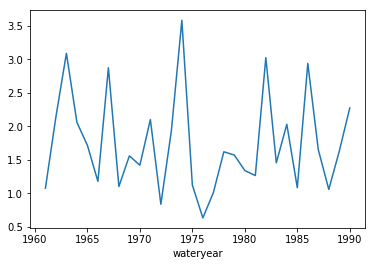

In [9]:
# Create Annual Maximum Series
baselineDF_max = baselineDF.groupby('wateryear').value.max()
baselineDF_max.plot()

# Create an array of maximum values by water year
AMS = baselineDF_max.values

In [10]:
def extreme_value_analysis_gev(AMS, ri=[2, 5, 10, 20, 50, 100], units='inches', label='Baseline'):
    """
    Fit a GEV model to Annual Maximum Series using the MLE estimation method,
    display the Density and Return Levels plots and calculate return levels for specified intervals.

    :param AMS: :class:`numpy.ndarray` maximum values by year
    :param list ri: List of return intervals
    :param string units: Data units
    :param string label: Data label
    
    :returns: return levels for the specified recurrence intervals in a Pandas Dataframe

    """
        
    print('GEV model fitted to Annual Maximum Series using MLE estimation method')
    # Calculate distribution parameters
    params = genextreme.fit(AMS)
    shape, location, scale = params

    # Fit of GEV distribution based on MLE estimation (default in SciPy)
    gev_fit = genextreme(*params)
    print('Estimated Parameters:')
    print('shape: {}, location: {}, scale: {}'.format(shape, location, scale))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
    
    ## DENSITY PLOT
    # x axis values for density plot
    x = np.linspace(gev_fit.ppf(0.001), gev_fit.ppf(0.999), 100)
    # plot
    #fig, ax = plt.subplots(figsize=(8, 6))
    ax1.plot(x, gev_fit.pdf(x), label = 'Fitted', color = 'k')
    ax1.hist(AMS, density = True, color = 'yellow', alpha = 0.75, label = "Empirical")
    ax1.set_title('Density Plot')
    ax1.set_xlabel('Precipitation({})'.format(units))
    ax1.set_ylabel('Probability')
    ax1.legend(loc='best', frameon=False)
    
    ## RETURN VALUE PLOT
    # Value indicating the frecuency of events per year
    # frec of 1 => yearly data (1 value per year)
    frec = 1
    # x axis values for return value plot
    T = np.arange(0.1, 100.1, 0.1)
    sT = gev_fit.isf(frec * 1./T)
    N = np.r_[1:len(AMS) + 1] * frec
    Nmax = max(N)
    # plot
    ax2.semilogx(T, sT)
    ax2.scatter(frec * Nmax/N, sorted(AMS)[::-1], color = 'orangered')
    ax2.set_title('Return Level Plot')
    ax2.set_xlabel('Return period')
    ax2.set_ylabel('Return level')
    ax2.grid(True)
    
    # Get Return Levels (precipitation values) for Return Periods
    rlevels =  [gev_fit.isf(1./i) for i in ri]
    print('Return Levels:')
    for idx, val in enumerate(ri):
        print('{}-year Return Level = '.format(val), rlevels[idx], units)
        
    # Return pandas dataframe
    return pd.DataFrame({'RI': ri, 'RL': rlevels, 'Label': label})


GEV model fitted to Annual Maximum Series using MLE estimation method
Estimated Parameters:
shape: -0.07494807455362251, location: 1.3933479370190371, scale: 0.5390652942187092
Return Levels:
2-year Return Level =  1.5936609800218537 inches
5-year Return Level =  2.2491140658259168 inches
10-year Return Level =  2.7147458746217867 inches
20-year Return Level =  3.1866852038118343 inches
50-year Return Level =  3.836617808580886 inches
100-year Return Level =  4.354280477009514 inches


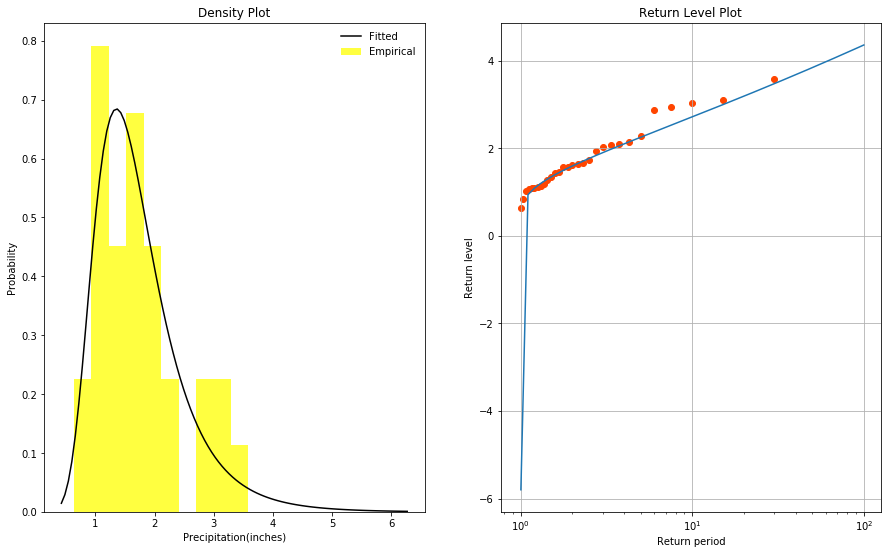

In [11]:
rl = extreme_value_analysis_gev(AMS)

### Approach 2: Peak Over Threshold/Parital Duration Series (PDS)

In [12]:
# Select threshold value

# Some analysis use lowest value from the Annual Maximum Series.
# This example uses the 95th percentile value from baseline data (Livneh 1961 - 1990)

threshold = threshold95
print(threshold)

0.8739868888669967


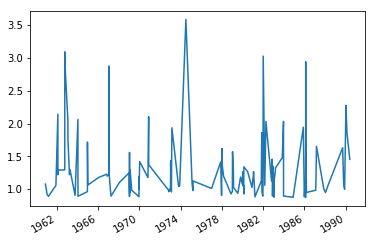

In [13]:
baselineDF.loc[baselineDF['value'] > threshold].value.plot()

In [14]:
# Create an array of all non-zero daily values 
PDS_baseline = baselineDF['value'].values
print('Number of observations =', len(PDS_baseline))
print('Number of exceedances =', (PDS_baseline > threshold).sum())

Number of observations = 2661
Number of exceedances = 133


In [15]:
# Functions adapted from https://github.com/wcarthur/extremes

def returnLevels(intervals, mu, xi, sigma, rate, npyr):
    """
    Calculate return levels for specified intervals for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param intervals: :class:`numpy.ndarray` or float of recurrence intervals
              to evaluate return levels for.
    :param float mu: Threshold parameter (also called location).
    :param float xi: Shape parameter.
    :param float sigma: Scale parameter.
    :param float rate: Rate of exceedances (i.e. number of observations greater
                       than `mu`, divided by total number of observations).
    :param float npyr: Number of observations per year.

    :returns: return levels for the specified recurrence intervals.

    """

    rlevels = mu + (sigma / xi) * (np.power(intervals * npyr * rate, xi) - 1.)
    return rlevels

def empReturnPeriod(data, npyr):
    """
    Returns the empirically-based recurrence interval (in years) for a set
    of observations.

    It is assumed the data are daily observations. If the observations are not
    daily, there are two options: set the ``npyr`` variable, or backfill the
    ``data`` variable with zero values to match the assumed length of the
    record.

    The highest return period should be (approximately) len(``data``)/``npyr``.

    :param data: :class:`numpy.ndarray` containing the observed values (with
                 missing values removed).
    :param float npy: Number of observations per year (default=365.25)

    :returns: Recurrence intervals for the observed data.
    :rtype: :class:`numpy.ndarray`
    """
    nobs = len(data)
    # Empirical return periods:
    emprp = 1. / (1. - np.arange(1, nobs + 1, 1) / (nobs + 1)) / npyr
    return emprp

In [16]:
def extreme_value_analysis_gp(PDS, threshold, ri=[2, 5, 10, 20, 50, 100], units='inches', label='Baseline'):
    """
    Fit a Generalised Pareto model to a Partial Duration Series using the MLE estimation method,
    display the Density and Return Levels plots and calculate return levels for specified intervals.

    :param PDS: :class:`numpy.ndarray` non zero daily values for time period
    :param list ri: List of return intervals
    :param string units: Data units
    :param string label: Data label
    
    :returns: return levels for the specified recurrence intervals in a Pandas Dataframe

    """
        
    print('GP model fitted to Partial Duration Series Series using MLE estimation method')
    # Calculate distribution parameters
    params = genpareto.fit(PDS[PDS > threshold] - threshold)
    shape, location, scale = params

    # Fit of GEV distribution based on MLE estimation (default in SciPy)
    gpa_fit = genpareto(*params)
    print('Estimated Parameters:')
    print('shape: {}, location: {}, scale: {}'.format(shape, location, scale))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ## DENSITY PLOT
    # x axis values for plot
    x = np.linspace(gpa_fit.ppf(0.001), gpa_fit.ppf(0.999), 100)
    # plot
    ax1.plot(x, gpa_fit.pdf(x), label = 'Modeled', color = 'k')
    ax1.hist(PDS, density = True, color = 'yellow', alpha = 0.75, label = "Empirical")
    ax1.set_title('Density Plot')
    ax1.set_xlabel('Precipitation(mm)')
    ax1.set_ylabel('Probability')
    ax1.legend(loc='best', frameon=False) 
    
    ## RETURN VALUE PLOT
    # x axis values for plot
    rate = float(len(PDS[PDS > threshold])) / float(len(PDS))
    npyr = len(PDS) / 30
    rlevels = returnLevels(np.array(ri), threshold, shape, scale, rate, npyr)

    emprp = empReturnPeriod(PDS, npyr)
    sortedmax = np.sort(PDS)

    # plot
    ax2.set_title('Return Level Plot')
    ax2.set_xlabel('Return period')
    ax2.set_ylabel('Return level')
    ax2.grid(True)
    ax2.semilogx(ri, rlevels, label = 'Modeled RP', color = 'k')
    ax2.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100, color='r', label="Empirical RP")
    ax2.legend(loc='best', frameon=False)
    
    # Get Return Levels (precipitation values) for Return Periods
    print('Return Levels:')
    for idx, val in enumerate(ri):
        print('{}-year Return Level = '.format(val), rlevels[idx], units)
    
    # Return pandas dataframe
    return pd.DataFrame({'RI': ri, 'RL': rlevels, 'Label': label})


GP model fitted to Partial Duration Series Series using MLE estimation method
Estimated Parameters:
shape: 0.15531150195018828, location: 0.00044769517130751376, scale: 0.3751068023390003


/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Return Levels:
2-year Return Level =  1.8484042609908977 inches
5-year Return Level =  2.3667924137388474 inches
10-year Return Level =  2.8109832101256336 inches
20-year Return Level =  3.3056616432448718 inches
50-year Return Level =  4.046914823310953 inches
100-year Return Level =  4.682071777867903 inches


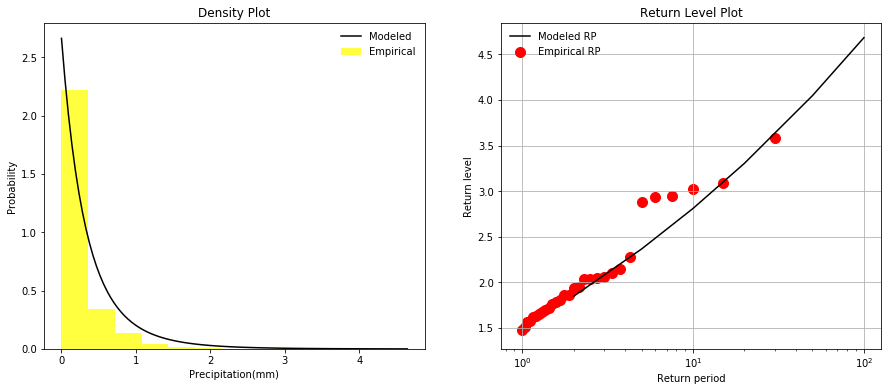

In [17]:
rl_baseline = extreme_value_analysis_gp(PDS_baseline, threshold, label='Livneh (1961-1990)')

Number of observations = 2899
Number of exceedances = 217
GP model fitted to Partial Duration Series Series using MLE estimation method
Estimated Parameters:
shape: 0.06358703789928716, location: 0.0008624125535267738, scale: 0.5060985105231937
Return Levels:
2-year Return Level =  2.3478632614064656 inches
5-year Return Level =  2.91379765486818 inches
10-year Return Level =  3.364359795011177 inches
20-year Return Level =  3.835224677668162 inches
50-year Return Level =  4.490393354555478 inches
100-year Return Level =  5.0119983402630215 inches


/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


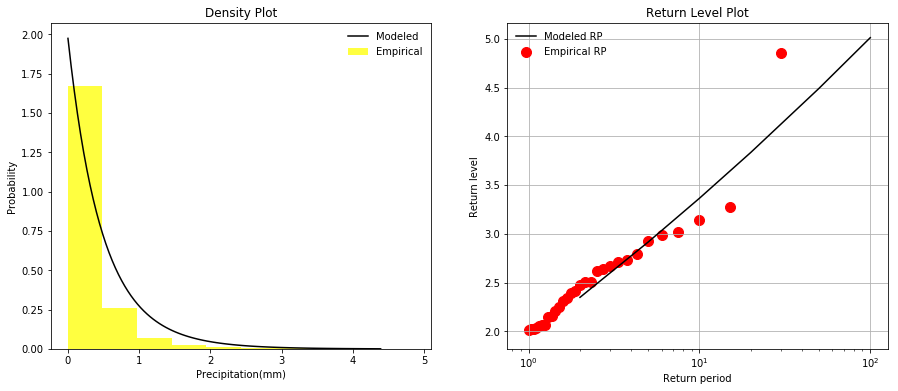

In [18]:
# Filter data by time period
modelMidDF = df.loc[(df['wateryear'] >= 2021) & (df['wateryear'] <= 2050) & (df['series'] == 'CNRM-CM5')]

# Filter out zero precip values
modelMidDF = modelMidDF.loc[(modelMidDF['value'] > 0)]

# Create an array of all non-zero daily values 
PDS_mid = modelMidDF['value'].values
print('Number of observations =', len(PDS_mid))
print('Number of exceedances =', (PDS_mid > threshold).sum())

rl_midcentury = extreme_value_analysis_gp(PDS_mid, threshold, label='CNRM-CM5 (2021-2050)')

Number of observations = 2798
Number of exceedances = 214
GP model fitted to Partial Duration Series Series using MLE estimation method
Estimated Parameters:
shape: 0.15280381221701947, location: 0.00017308683261224716, scale: 0.4528606885649179
Return Levels:
2-year Return Level =  2.358830476003746 inches
5-year Return Level =  3.027391189359963 inches
10-year Return Level =  3.5991119455369263 inches
20-year Return Level =  4.234709899308431 inches
50-year Return Level =  5.185193580249134 inches
100-year Return Level =  5.998001210050358 inches


/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


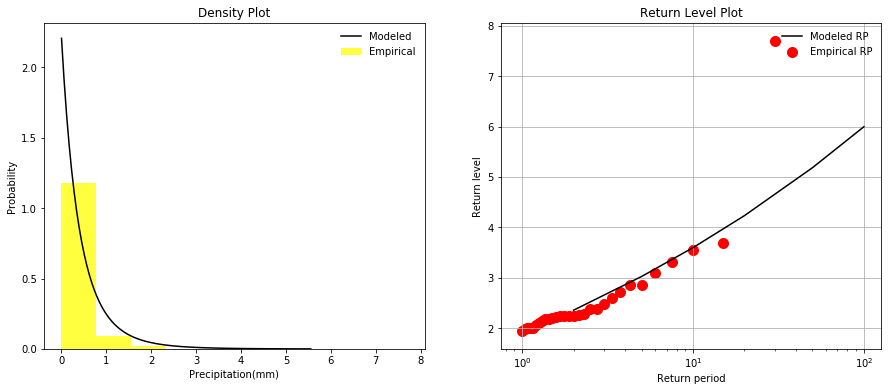

In [19]:
# Filter data by baseline time period
modelEndDF = df.loc[(df['wateryear'] >= 2071) & (df['wateryear'] <= 2099) & (df['series'] == 'CNRM-CM5')]

# Filter out zero precip values
modelEndDF = modelEndDF.loc[(modelEndDF['value'] > 0)]

# Create an array of all non-zero daily values 
PDS_end = modelEndDF['value'].values
print('Number of observations =', len(PDS_end))
print('Number of exceedances =', (PDS_end > threshold).sum())

rl_endcentury = extreme_value_analysis_gp(PDS_end, threshold, label='CNRM-CM5 (2071-2099)')

In [20]:
rl = pd.concat([rl_baseline, rl_midcentury, rl_endcentury])
rl

,Label,RI,RL
0,Livneh (1961-1990),2,1.848404
1,Livneh (1961-1990),5,2.366792
2,Livneh (1961-1990),10,2.810983
3,Livneh (1961-1990),20,3.305662
4,Livneh (1961-1990),50,4.046915
5,Livneh (1961-1990),100,4.682072
0,CNRM-CM5 (2021-2050),2,2.347863
1,CNRM-CM5 (2021-2050),5,2.913798
2,CNRM-CM5 (2021-2050),10,3.364360
3,CNRM-CM5 (2021-2050),20,3.835225


### Compare Return Levels between baseline and projections

Text(0.5,0,'Return Interval (Years)')

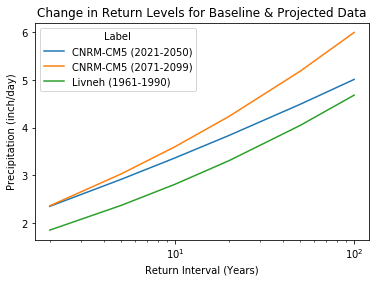

In [26]:
ax = rl.pivot(index='RI', columns='Label', values='RL').plot(logx=True, title='Change in Return Levels for Baseline & Projected Data')
ax.set_ylabel('Precipitation (inch/day)')
ax.set_xlabel('Return Interval (Years)')